In [85]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [86]:
def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

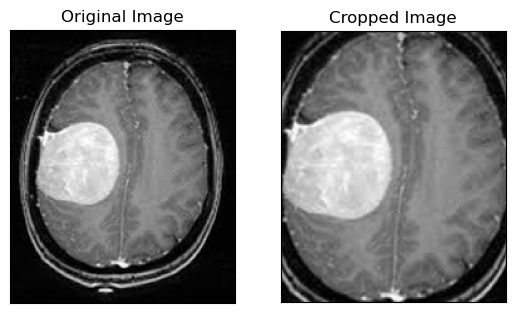

In [87]:
ex_img = cv2.imread('Brain Tumor/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [88]:
#Data Augmentation
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [89]:
augmented_path = 'Brain Tumor/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 253
X shape is: (253, 240, 240, 3)
y shape is: (253, 1)


In [90]:
def plot_sample_images(X, y, n=50):

    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
            
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

In [91]:
def split_data(X, y, test_size=0.2):

    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [92]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [93]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 177
number of development examples = 38
number of test examples = 38
X_train shape: (177, 240, 240, 3)
Y_train shape: (177, 1)
X_val (dev) shape: (38, 240, 240, 3)
Y_val (dev) shape: (38, 1)
X_test shape: (38, 240, 240, 3)
Y_test shape: (38, 1)


In [94]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [95]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [96]:
def build_model(input_shape):

    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    
    return model

In [97]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [98]:
model = build_model(IMG_SHAPE)

In [99]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d_4 (ZeroPadd  (None, 244, 244, 3)       0         
 ing2D)                                                          
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation_4 (Activation)   (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

In [100]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [101]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')
#explore the TensorBoard logs to gain insights into your model's performance.

In [102]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath="cnn-parameters-improvement-{epoch:-2d}-{val_accuracy:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("Brain Tumor/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max'))

In [119]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.0561 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 1-0.74.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 1-0.74.model\assets


6/6 [==============================] - 9s 1s/step - loss: 0.0561 - accuracy: 0.9944 - val_loss: 0.5403 - val_accuracy: 0.7368
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.0586 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 2-0.79.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 2-0.79.model\assets


6/6 [==============================] - 11s 2s/step - loss: 0.0586 - accuracy: 0.9944 - val_loss: 0.5238 - val_accuracy: 0.7895
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.0474 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 3-0.74.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 3-0.74.model\assets


6/6 [==============================] - 12s 2s/step - loss: 0.0474 - accuracy: 0.9944 - val_loss: 0.5332 - val_accuracy: 0.7368
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 1.0000INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 4-0.79.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 4-0.79.model\assets


6/6 [==============================] - 12s 2s/step - loss: 0.0430 - accuracy: 1.0000 - val_loss: 0.5184 - val_accuracy: 0.7895
Epoch 5/10
6/6 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 5-0.74.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 5-0.74.model\assets


6/6 [==============================] - 11s 2s/step - loss: 0.0465 - accuracy: 0.9944 - val_loss: 0.5394 - val_accuracy: 0.7368
Epoch 6/10
6/6 [==============================] - ETA: 0s - loss: 0.0435 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 6-0.79.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 6-0.79.model\assets


6/6 [==============================] - 11s 2s/step - loss: 0.0435 - accuracy: 0.9944 - val_loss: 0.5148 - val_accuracy: 0.7895
Epoch 7/10
6/6 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 7-0.74.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 7-0.74.model\assets


6/6 [==============================] - 11s 2s/step - loss: 0.0419 - accuracy: 0.9944 - val_loss: 0.5338 - val_accuracy: 0.7368
Epoch 8/10
6/6 [==============================] - ETA: 0s - loss: 0.0375 - accuracy: 1.0000INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 8-0.76.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 8-0.76.model\assets


6/6 [==============================] - 11s 2s/step - loss: 0.0375 - accuracy: 1.0000 - val_loss: 0.5096 - val_accuracy: 0.7632
Epoch 9/10
6/6 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 1.0000INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 9-0.76.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 9-0.76.model\assets


6/6 [==============================] - 11s 2s/step - loss: 0.0346 - accuracy: 1.0000 - val_loss: 0.5169 - val_accuracy: 0.7632
Epoch 10/10
6/6 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 1.0000INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement-10-0.74.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement-10-0.74.model\assets


6/6 [==============================] - 11s 2s/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.5217 - val_accuracy: 0.7368
Elapsed time: 0:1:48.5


In [106]:
# start_time = time.time()

# model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

# end_time = time.time()
# execution_time = (end_time - start_time)
# print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 1-0.76.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 1-0.76.model\assets


6/6 [==============================] - 12s 2s/step - loss: 0.0881 - accuracy: 0.9944 - val_loss: 0.5415 - val_accuracy: 0.7632
Epoch 2/3
6/6 [==============================] - ETA: 0s - loss: 0.0818 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 2-0.74.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 2-0.74.model\assets


6/6 [==============================] - 13s 2s/step - loss: 0.0818 - accuracy: 0.9944 - val_loss: 0.5461 - val_accuracy: 0.7368
Epoch 3/3
6/6 [==============================] - ETA: 0s - loss: 0.0836 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 3-0.74.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 3-0.74.model\assets


6/6 [==============================] - 14s 3s/step - loss: 0.0836 - accuracy: 0.9944 - val_loss: 0.5419 - val_accuracy: 0.7368
Elapsed time: 0:0:40.1


In [107]:
# start_time = time.time()

# model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

# end_time = time.time()
# execution_time = (end_time - start_time)
# print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 [==============================] - ETA: 0s - loss: 0.0755 - accuracy: 0.9887INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 1-0.74.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 1-0.74.model\assets


6/6 [==============================] - 15s 3s/step - loss: 0.0755 - accuracy: 0.9887 - val_loss: 0.5351 - val_accuracy: 0.7368
Epoch 2/3
6/6 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9887INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 2-0.74.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 2-0.74.model\assets


6/6 [==============================] - 13s 2s/step - loss: 0.0958 - accuracy: 0.9887 - val_loss: 0.5510 - val_accuracy: 0.7368
Epoch 3/3
6/6 [==============================] - ETA: 0s - loss: 0.0816 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 3-0.76.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 3-0.76.model\assets


6/6 [==============================] - 12s 2s/step - loss: 0.0816 - accuracy: 0.9944 - val_loss: 0.5266 - val_accuracy: 0.7632
Elapsed time: 0:0:40.4


In [108]:
# start_time = time.time()

# model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

# end_time = time.time()
# execution_time = (end_time - start_time)
# print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
6/6 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 1-0.79.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 1-0.79.model\assets


6/6 [==============================] - 13s 2s/step - loss: 0.0718 - accuracy: 0.9944 - val_loss: 0.5400 - val_accuracy: 0.7895
Epoch 2/3
6/6 [==============================] - ETA: 0s - loss: 0.0629 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 2-0.76.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 2-0.76.model\assets


6/6 [==============================] - 13s 2s/step - loss: 0.0629 - accuracy: 0.9944 - val_loss: 0.5270 - val_accuracy: 0.7632
Epoch 3/3
6/6 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9944INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 3-0.79.model\assets


INFO:tensorflow:Assets written to: Brain Tumor\cnn-parameters-improvement- 3-0.79.model\assets


6/6 [==============================] - 13s 2s/step - loss: 0.0574 - accuracy: 0.9944 - val_loss: 0.5215 - val_accuracy: 0.7895
Elapsed time: 0:0:39.1


In [120]:
history = model.history.history

In [121]:
for key in history.keys():
    print(key)

loss
accuracy
val_loss
val_accuracy


In [122]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

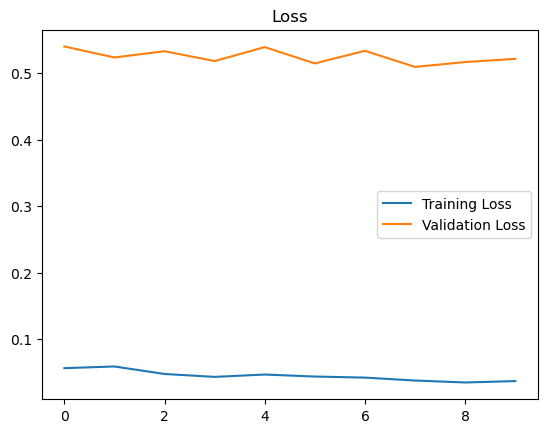

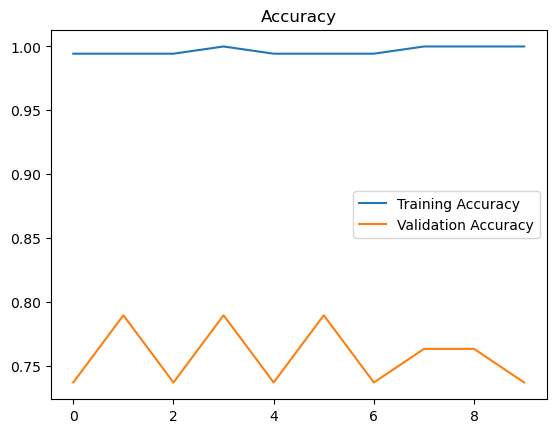

In [123]:
plot_metrics(history) 

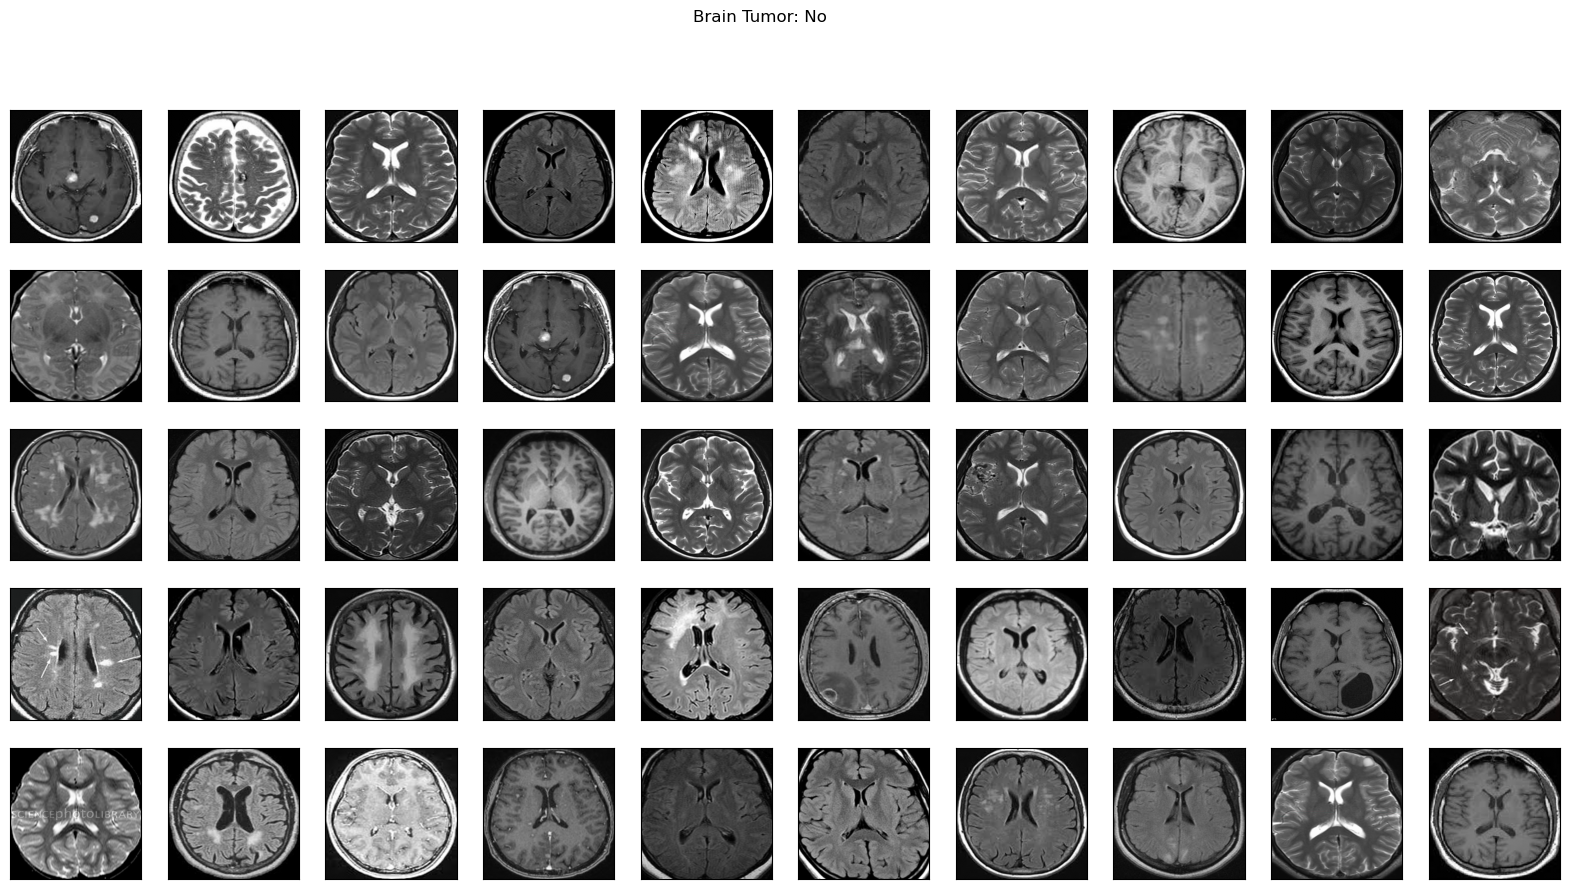

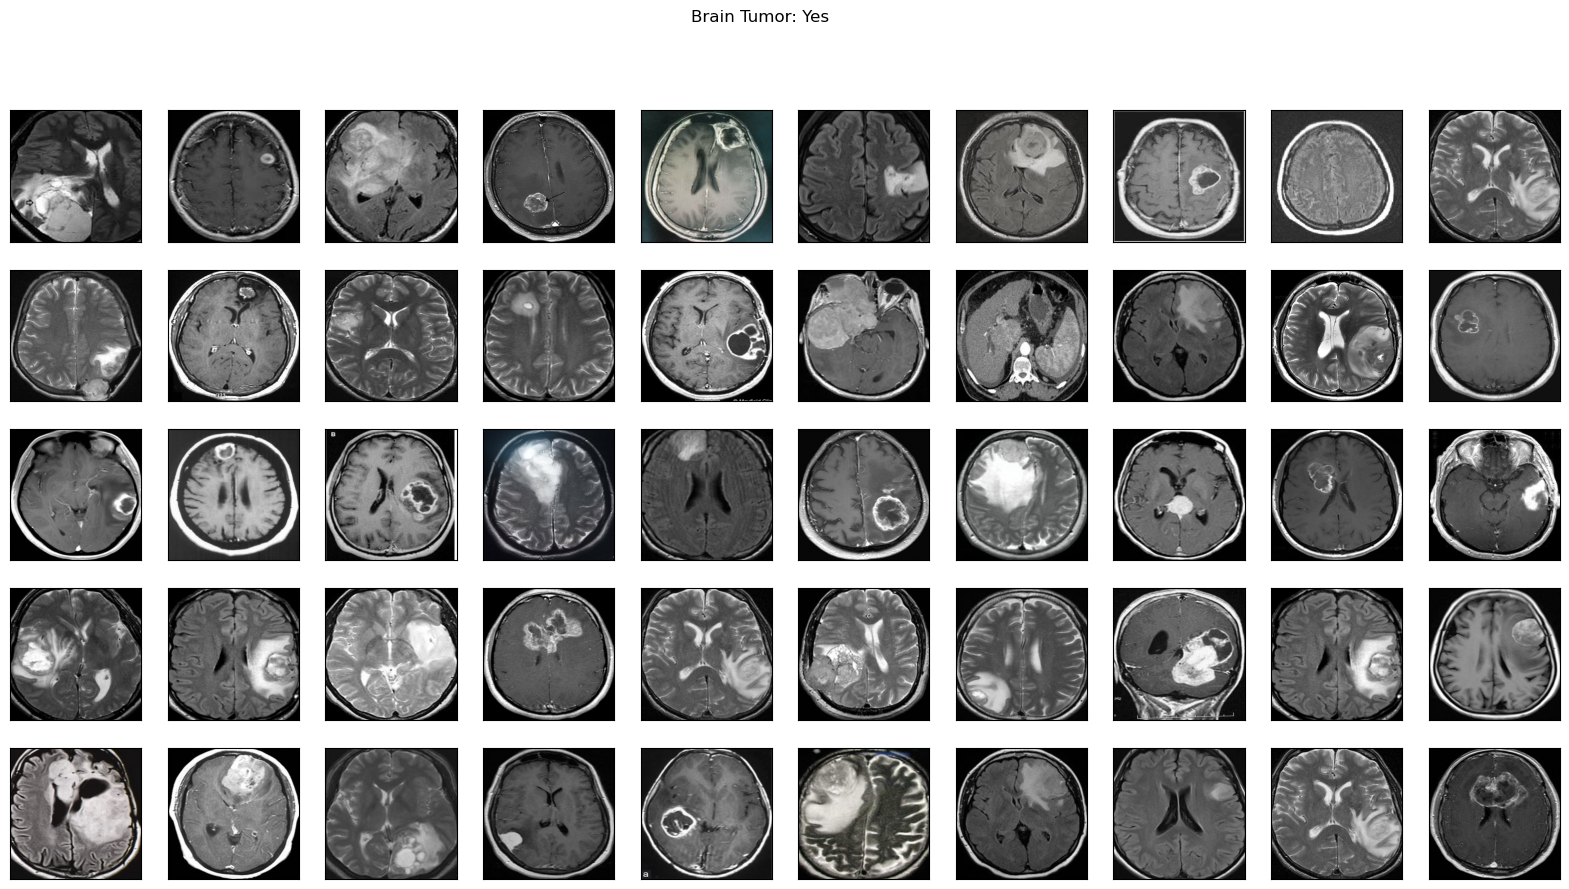

In [124]:
plot_sample_images(X, y)